# 📊 Portfolio Management Strategies

This notebook explores various **portfolio management strategies**, including Markowitz's Mean-Variance Optimization, Minimum Variance, and Target Volatility portfolios. These strategies are essential for constructing portfolios that aim to optimize returns while managing risk.

---


In [1]:
import yfinance as yf 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import riskfolio as rp
import cvxpy
from scipy.linalg import sqrtm

---
# **1. 📥 Data Acquisition**

In [2]:
# ======= I. Data acquisition =======
tickers_list = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'TSLA', 'NVDA', 'PYPL', 'ADBE', 'A', 'T', 'V', 'MA', 'INTU', 'CRM', 'CSCO', 'ORCL', 'IBM', 'QCOM', 'TXN', 'MU', 'AMD', 'ADSK', 'NOW']
data = yf.download(tickers_list, start="2020-01-01", end="2024-01-01")['Adj Close']

[*********************100%%**********************]  23 of 23 completed


In [3]:
# ======= II. Data preprocessing =======
nb_nan = data.isna().sum().sum()
print(f'There are {nb_nan} missing values in the dataset')

train_start = '2020-01-01'
train_end = '2021-12-31'
train_sample = data.loc[train_start:train_end].dropna(axis=1)

test_start = '2022-01-01'
test_end = '2024-01-01'
test_sample = data.loc[test_start:test_end].dropna(axis=1)

There are 0 missing values in the dataset


---
# **2. 📊 Data Preprocessing**

In [4]:
def covmat_expectret_returnsdf(df: pd.DataFrame):
    returns = df.pct_change().dropna()
    covmat = returns.cov()
    expect_returns = returns.mean() * 252
    return covmat, expect_returns, returns

In [5]:
covmat, expect_returns, returns = covmat_expectret_returnsdf(train_sample)

---
# **3.🔍 Computing portfolios**

In [6]:
def flexible_optimization(
    returns_df: pd.DataFrame,
    cov_matrix: pd.DataFrame,
    expected_return_vector: np.array,
    model: str,
    risk_measure: str,
    objective_function: str,
):
    """
    Compute the optimal weights of a portfolio using Markowitz efficient frontier.

    Args:
        returns_df (pd.DataFrame): DataFrame containing the returns of each combination.
        cov_matrix (pd.DataFrame): Covariance matrix of the returns.
        expected_return_vector (np.array): Expected returns of each combination.
        model (str): Model used for the optimization. Possible inputs : "Classic", "BL" (Black-Litterman) or "FM" (Factor Model).
        risk_measure (str): Risk measure used for the optimization. Possible inputs : "MV" (Mean-Variance), "CDaR" (Conditional Drawdown at Risk), "Volatility" or "MVaR" (Mean-Value at Risk).
        objective_function (str): Objective function used for the optimization. Possible inputs : "MaxRet" (Maximize return), "MinRisk" (Minimize risk), "Utility" or "Sharpe" (Maximize Sharpe ratio).

    Returns:
        weights (pd.DataFrame): DataFrame containing the optimal weights for each combination.
    """
    # ======== I. Initializing with the right inputs
    port = rp.Portfolio(returns=returns_df)
    port.mu = expected_return_vector.T
    port.cov = cov_matrix.cov()

    # ---------
    hist = True  # Use historical scenarios for risk measures that depend on scenarios
    rf = 0  # Risk free rate
    aversion = 0  # Risk aversion factor, only useful when obj is 'Utility'

    # ======== II. Estimate optimal portfolio
    w = port.optimization(
        model=model,
        rm=risk_measure,
        obj=objective_function,
        rf=rf,
        l=aversion,
        hist=hist,
    )

    # ---------
    if w is None:
        weights = pd.DataFrame(np.zeros(returns_df.shape[1])).T
    else:
        weights = w.T

    return weights

In [7]:
def targetVolatility_optimization(
    exp_ret: np.array,
    cov: np.array,
    boundary: np.array,
    target_volatility: float,
):
    """
    This function will compute the optimal weights of a portfolio using a target volatility.
    If the first attempt fails, it will increase the target volatility and retry once.

    Args:
        exp_ret (np.array): Expected returns of each combination.
        cov (np.array): Covariance matrix of the returns.
        boundary (np.array): Lower and upper bounds for each asset.
        vol_target (float): Target volatility.

    Returns:
        opt_x (pd.DataFrame): A DataFrame containing the optimal weights for each combination.
    """
    # ======== I. Setting up the optimization problem
    N = len(exp_ret)
    cov += np.eye(cov.shape[0]) * 1e-6  # Regularize if necessary

    # -------- Decision variable
    x = cvxpy.Variable(N)

    # -------- Constant vectors and matrices
    mu = cvxpy.Constant(exp_ret)
    G = cvxpy.Constant(np.real(sqrtm(cov)))

    # -------- Objective: Maximize expected returns
    obj = cvxpy.Maximize(x @ mu)

    # -------- Constraints
    def setup_constraints(vol_target):
        cons = [cvxpy.norm(G @ x, 2) <= vol_target]  # Volatility constraint
        for i in range(N):
            cons.append(boundary[i, 0] <= x[i])  # Lower bound
            cons.append(x[i] <= boundary[i, 1])  # Upper bound
        cons.append(cvxpy.sum(x) == 1)
        return cons

    # -------- Attempt to solve the problem
    for attempt in range(2):  # Try up to two attempts
        cons = setup_constraints(target_volatility)
        prob = cvxpy.Problem(obj, cons)

        try:
            prob.solve(ignore_dpp=True, verbose=False)
            opt_x = x.value
            if opt_x is not None:
                weights = pd.DataFrame(opt_x).T
                return weights  # Return solution if successful
        except Exception as e:
            pass

        # If the first attempt fails, increase vol_target
        if attempt == 0:
            target_volatility += 0.1 / np.sqrt(252)

    # Return zeros if both attempts fail
    weights = pd.DataFrame(np.zeros(N)).T
    
    return weights

In [8]:
# ======= I. Classic Mean-Variance (Markowitz) optimization =======
markowitz_weights = flexible_optimization(returns, covmat, expect_returns, 'Classic', 'MV', 'Sharpe')
markowitz_portfolio = pd.DataFrame(markowitz_weights.values, columns=train_sample.columns, index=['markowitz_weights'])
markowitz_portfolio = markowitz_portfolio.T

# ======= II. Minimum Risk optimization =======
min_risk_weights = flexible_optimization(returns, covmat, expect_returns, 'Classic', 'MV', 'MinRisk')
min_risk_portfolio = pd.DataFrame(min_risk_weights.values, columns=train_sample.columns, index=['min_risk_weights'])
min_risk_portfolio = min_risk_portfolio.T

# ======= III. Target Volatility optimization =======
target_volatility = 0.2 * np.sqrt(252)
N = len(expect_returns)
boundary = np.array([[0, 0.25]] * N)
targetVolatility_weights = targetVolatility_optimization(expect_returns, covmat, boundary, target_volatility)
targetVolatility_portfolio = pd.DataFrame(targetVolatility_weights.values, columns=train_sample.columns, index=['targetVolatility_weights'])
targetVolatility_portfolio = targetVolatility_portfolio.T

---
# **4. 📈 Comparing the results**

In [9]:
def compute_stats(
    returns: pd.Series,
    market_returns: pd.Series,
    risk_free_rate: float = 0.0,
    frequence: str = "daily",
):
    """
    Compute the statistics of the investment.

    Args:
        returns (pd.Series): Series of returns of the investment.
        market_returns (pd.Series): Series of returns of the market index for comparison.
        risk_free_rate (float): Risk-free rate for certain calculations.
        frequence (str): Frequence of the returns.

    Returns:
        stats (dict): Dictionary containing the statistics of the investment, including:

        ======= Returns distribution statistics =======
        - **Expected Return**: The annualized mean return, indicating average performance.
        - **Volatility**: Standard deviation of returns, representing total risk.
        - **Downside Deviation**: Standard deviation of negative returns, used in risk-adjusted metrics like Sortino Ratio.
        - **Median Return**: The median of returns, a measure of central tendency.
        - **Skew** and **Kurtosis**: Describe the distribution shape, with skew indicating asymmetry and kurtosis indicating tail heaviness.

        ======= Risk measures =======
        - **Maximum Drawdown**: Largest observed loss from peak to trough, a measure of downside risk.
        - **Max Drawdown Duration**: Longest period to recover from drawdown, indicating risk recovery time.
        - **VaR 95** and **CVaR 95**: Value at Risk and Conditional Value at Risk at 95%, giving the maximum and average expected losses in worst-case scenarios.

        ======= Market sensitivity measures =======
        - **Beta**: Sensitivity to market movements.
        - **Alpha**: Risk-adjusted return above the market return.
        - **Upside/Downside Capture Ratios**: Percent of market gains or losses captured by the investment.
        - **Tracking Error**: Volatility of return differences from the market.

        ======= Performance measures =======
        - **Sharpe**: Risk-adjusted returns per unit of volatility.
        - **Sortino Ratio**: Risk-adjusted return accounting only for downside volatility.
        - **Treynor Ratio**: Return per unit of systematic (market) risk.
        - **Information Ratio**: Excess return per unit of tracking error.

        - **Sterling Ratio**: Return per unit of average drawdown.
        - **Calmar Ratio**: Return per unit of maximum drawdown.
    """
    # ======= 0. Initialization =======
    frequence_dict = {"daily": 252, "5m": 19656, "1m": 98280}
    adjusted_frequence = frequence_dict[frequence]

    cumulative_returns = (1 + returns).cumprod()

    # ======= I. Returns distribution statistics =======
    expected_return = returns.mean() * adjusted_frequence
    volatility = returns.std() * np.sqrt(adjusted_frequence)
    downside_deviation = returns[returns < 0].std() * np.sqrt(adjusted_frequence) if returns[returns < 0].sum() != 0 else 0
    median_return = returns.median() * adjusted_frequence
    skew = returns.skew()
    kurtosis = returns.kurtosis()

    # ======= II. Risk measures =======
    # ------ Maximum Drawdown and Duration
    running_max = cumulative_returns.cummax().replace(0, 1e-10)
    drawdown = (cumulative_returns / running_max) - 1
    drawdown_durations = (drawdown < 0).astype(int).groupby((drawdown == 0).cumsum()).cumsum()

    maximum_drawdown = drawdown.min()
    max_drawdown_duration = drawdown_durations.max()

    # ------ Value at Risk and Conditional Value at Risk
    var_95 = returns.quantile(0.05)
    cvar_95 = returns[returns <= var_95].mean()

    # ======= III. Market sensitivity measures =======
    # ------ Beta and Alpha (Jensens's)
    beta = returns.cov(market_returns) / market_returns.var()
    alpha = expected_return - beta * (market_returns.mean() * adjusted_frequence)

    # ------ Capture Ratios
    upside_capture = returns[market_returns > 0].mean() / market_returns[market_returns > 0].mean()
    downside_capture = returns[market_returns < 0].mean() / market_returns[market_returns < 0].mean()

    # ------ Tracking Error
    tracking_error = returns.sub(market_returns).std() * np.sqrt(adjusted_frequence)

    # ======= IV. Performance measures =======
    # ------ Sharpe, Sortino, Treynor, and Information Ratios
    sharpe_ratio = (expected_return - risk_free_rate) / volatility if volatility != 0 else 0
    sortino_ratio = expected_return / downside_deviation if downside_deviation != 0 else 0
    treynor_ratio = expected_return / beta if beta != 0 else 0
    information_ratio = (expected_return - market_returns.mean() * adjusted_frequence) / tracking_error if tracking_error != 0 else 0

    # ------ Sterling, and Calmar Ratios
    average_drawdown = abs(drawdown[drawdown < 0].mean()) if drawdown[drawdown < 0].sum() != 0 else 0
    sterling_ratio = (expected_return - risk_free_rate) / average_drawdown if average_drawdown != 0 else 0
    calmar_ratio = expected_return / abs(maximum_drawdown) if maximum_drawdown != 0 else 0

    # ======= IV. Store the statistics =======
    stats = {
        "expected_return": expected_return,
        "volatility": volatility,
        "downside_deviation": downside_deviation,
        "median_return": median_return,
        "skew": skew,
        "kurtosis": kurtosis,
        "maximum_drawdown": maximum_drawdown,
        "max_drawdown_duration": max_drawdown_duration,
        "var_95": var_95,
        "cvar_95": cvar_95,
        "beta": beta,
        "alpha": alpha,
        "upside_capture": upside_capture,
        "downside_capture": downside_capture,
        "tracking_error": tracking_error,
        "sharpe_ratio": sharpe_ratio,
        "sortino_ratio": sortino_ratio,
        "treynor_ratio": treynor_ratio,
        "information_ratio": information_ratio,
        "sterling_ratio": sterling_ratio,
        "calmar_ratio": calmar_ratio,
    }

    return stats

Markowitz Portfolio Statistics
{'expected_return': 0.08211521812642174, 'volatility': 0.2244878621385082, 'downside_deviation': 0.1495584037319451, 'median_return': 0.0746362713489287, 'skew': -0.14613506604653215, 'kurtosis': 0.6287663205905996, 'maximum_drawdown': -0.2331993129503943, 'max_drawdown_duration': 359, 'var_95': -0.02473297329229997, 'cvar_95': -0.03222328583563352, 'beta': 0.7148105906363981, 'alpha': 0.04178171806867311, 'upside_capture': 0.7246704281506338, 'downside_capture': 0.6997217293586894, 'tracking_error': 0.13271855517074313, 'sharpe_ratio': 0.36578912260190244, 'sortino_ratio': 0.5490511805247508, 'treynor_ratio': 0.11487689074851885, 'information_ratio': 0.19356585777382182, 'sterling_ratio': 0.9336491911814383, 'calmar_ratio': 0.35212461429459324}


Minimum Risk Portfolio Statistics
{'expected_return': 0.04736264671927704, 'volatility': 0.24345923042036108, 'downside_deviation': 0.16831802374116883, 'median_return': -0.004467025441834415, 'skew': -0.1857531

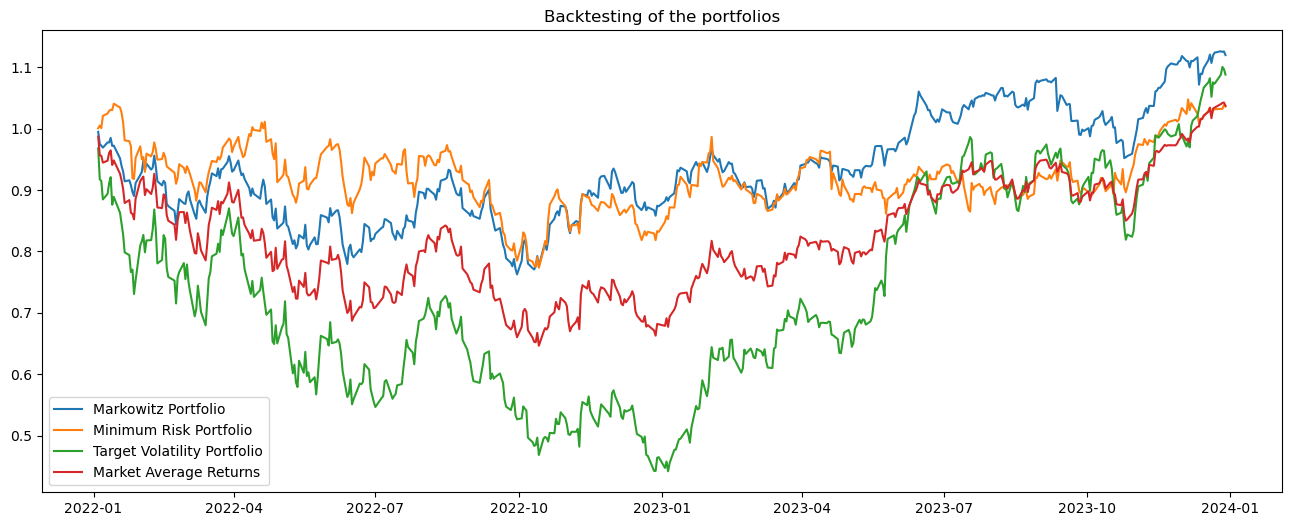

In [10]:
test_sample_returns = test_sample.pct_change().dropna()

benchmark_returns = test_sample_returns.mean(axis=1)
benchmark_returns = benchmark_returns
benchmark_cumreturns = (1 + benchmark_returns).cumprod()

# ======= IV. Backtesting =======
markowitz_portfolio_returns = (markowitz_portfolio.T @ test_sample_returns.T).T.iloc[:, 0]
min_risk_portfolio_returns = (min_risk_portfolio.T @ test_sample_returns.T).T.iloc[:, 0]
targetVolatility_portfolio_returns = (targetVolatility_portfolio.T @ test_sample_returns.T).T.iloc[:, 0]

markowitz_portfolio_cumreturns = (1 + markowitz_portfolio_returns).cumprod()
min_risk_portfolio_cumreturns = (1 + min_risk_portfolio_returns).cumprod()
targetVolatility_portfolio_cumreturns = (1 + targetVolatility_portfolio_returns).cumprod()

# ======= V. Compute the statistics =======
markowitz_stats = compute_stats(returns=markowitz_portfolio_returns, market_returns=benchmark_returns)
min_risk_stats = compute_stats(returns=min_risk_portfolio_returns, market_returns=benchmark_returns)
targetVolatility_stats = compute_stats(returns=targetVolatility_portfolio_returns, market_returns=benchmark_returns)

print('Markowitz Portfolio Statistics')
print(markowitz_stats)
print('\n')
print('Minimum Risk Portfolio Statistics')
print(min_risk_stats)
print('\n')
print('Target Volatility Portfolio Statistics')
print(targetVolatility_stats)

# ======= VI. Plot the results =======
plt.figure(figsize=(16, 6))
plt.plot(markowitz_portfolio_cumreturns, label='Markowitz Portfolio')
plt.plot(min_risk_portfolio_cumreturns, label='Minimum Risk Portfolio')
plt.plot(targetVolatility_portfolio_cumreturns, label='Target Volatility Portfolio')
plt.plot(benchmark_cumreturns, label='Market Average Returns')
plt.legend()
plt.title('Backtesting of the portfolios')
plt.show()